<a href="https://colab.research.google.com/github/kennetholson/Happy-Camper/blob/master/KE_NN_dogs_momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Epileptic seizure prediction
---
Based on Kaggle competition American Epilepsy Society Seizure Prediction Challenge
https://www.kaggle.com/c/seizure-prediction

In [0]:
#Importing libraries
import os, sys, pickle, itertools

#import joblib

import numpy as np
import math as math

from scipy.io import loadmat
from scipy.signal import resample #, butter, lfilter

import sklearn.linear_model

import sklearn.metrics
from sklearn.preprocessing import StandardScaler

In [2]:
#Check if we have a GPU

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#Check the versions - from my good friend Dat Nguyen

print('Python version: %s' % sys.version.split(' ')[0])
print('TensorFlow version: %s' % tf.__version__)

Python version: 3.6.7
TensorFlow version: 1.12.0


## Download Dataset using Kaggle API##

---
(This whole section for getting data from Kaggle is borrowed from my good friend Dat Nguyen)

### Step 1: Create a API Token in Kaggle Account 

* Go to Kaggle --> My Account --> Create New API Token

* Reference:  https://stackoverflow.com/questions/49310470/using-kaggle-datasets-into-google-colab


### Step 2: Upload your `kaggle.json` to Google Colab
 
 * Your kaggle.json is a "key" to let you use Kaggle API to download dataset from their website.
 
 
 ### Step 3: Download `American Epilespy Seizure` Dataset (Only the Dog Version for now)



In [0]:
# Install the Kaggle API client
!pip install -q kaggle
!apt-get install pv  >> /dev/null    # extract .tar file
# Upload Json File
if not os.path.isfile('kaggle.json'):
  from google.colab import files
  files.upload() 

In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle 
%%bash

mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json  #  avoids a warning on Kaggle tool startup.

printf "American Epilepsy Dataset:\n\n"
kaggle competitions files seizure-prediction 

#printf "\nStarting to download all dataset...\n"
#kaggle competitions download seizure-prediction

# To download a particular file. Use: 
kaggle competitions download seizure-prediction -f Dog_5.tar.gz

American Epilepsy Dataset:

name                   size  creationDate         
--------------------  -----  -------------------  
Dog_1.tar.gz            4GB  2014-08-22 16:44:38  
Dog_2.tar.gz            6GB  2014-08-22 18:49:32  
Dog_3.tar.gz            9GB  2014-08-22 21:51:20  
Dog_4.tar.gz            9GB  2014-08-22 21:53:44  
Dog_5.tar.gz            3GB  2014-08-21 19:35:13  
Patient_1.tar.gz       14GB  2014-08-22 17:32:56  
Patient_2.tar.gz       15GB  2014-08-22 17:40:11  
sampleSubmission.csv  117KB  2014-08-25 15:08:59  
Dog_5.tar.gz: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
DATASET_DIR = './output'

if not os.path.isdir(DATASET_DIR):
  os.mkdir(DATASET_DIR)
  
print('Extracting Dog_5')
!pv  Dog_5.tar.gz | tqdm --unit B --bytes --unit_scale --total $(du -sb Dog_5.tar.gz | awk '{print $1}')| tar xzf - -C output


Extracting Dog_5
100% 2.60G/2.60G [01:54<00:00, 10.6MB/s]2.60GiB 0:01:54 [23.3MiB/s] [================================>] 100%            
100% 2.60G/2.60G [01:54<00:00, 24.4MB/s]


##Content of the file:
* data: a matrix of EEG sample values arranged row x column as electrode x time.
* data_length_sec: the time duration of each data row
* sampling_frequency: the number of data samples representing 1 second of EEG data.
* channels: a list of electrode names corresponding to the rows in the data field
* sequence: the index of the data segment within the one hour series of clips. For example, preictal_segment_6.mat has a sequence number of 6, and represents the iEEG data from 50 to 60 minutes into the preictal data.

In [7]:
#Content of the example file]
m = loadmat('./output/Dog_5/Dog_5_preictal_segment_0007.mat')
d = m
print(d)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug 21 01:00:00 2014', '__version__': '1.0', '__globals__': [], 'preictal_segment_7': array([[(array([[-25, -29, -17, ...,  42,  41,  24],
       [ 36,  32,  33, ..., -45, -44, -35],
       [-18, -16,  -8, ..., -10,  -6, -21],
       ...,
       [ -9,   0, -19, ..., -33, -23, -11],
       [ 19,  18,   5, ..., -20, -38, -45],
       [ -1,   3,   4, ...,  18,  29,  22]], dtype=int16), array([[600]], dtype=uint16), array([[399.6097561]]), array([[array(['NVC0905_22_004_Ecog_c001'], dtype='<U24'),
        array(['NVC0905_22_004_Ecog_c002'], dtype='<U24'),
        array(['NVC0905_22_004_Ecog_c003'], dtype='<U24'),
        array(['NVC0905_22_004_Ecog_c005'], dtype='<U24'),
        array(['NVC0905_22_004_Ecog_c006'], dtype='<U24'),
        array(['NVC0905_22_004_Ecog_c007'], dtype='<U24'),
        array(['NVC0905_22_004_Ecog_c008'], dtype='<U24'),
        array(['NVC0905_22_004_Ecog_c009'], dtype='<U24'),
        array(['

##Using moving averages to smooth out the data

---
 ### Step 1. Get a list of all the files
 Files with *preictal_segment* in the name contain fragments of pre-seizure (within 1 hour prior to seizure) EEG.
 Files with *interictal_segment* in the name contain fragments of non-seziure/normal EEG.
 ### Step 2. Smooth out each row of the EEG matrix using *momentum* function

 Matrix dimensions: *Rows - Number of electrodes, Columns -  data_length_sec X sampling_frequency*
 
 ### Step 3.  Slide a window through the the smoothed matrix

In [0]:
def momentum (z):
  n_iter = len(z)
  beta = 0.9
  temp = np.zeros((len(z)))
  
  for k in range(1,n_iter-1):
    temp[k+1] = beta * temp[k] + (1-beta) * z[k] 
    
  return temp
  


###Visualize raw and smoothed data
Correct beta in the **momentum** to achieve a smoother curve or vice versa

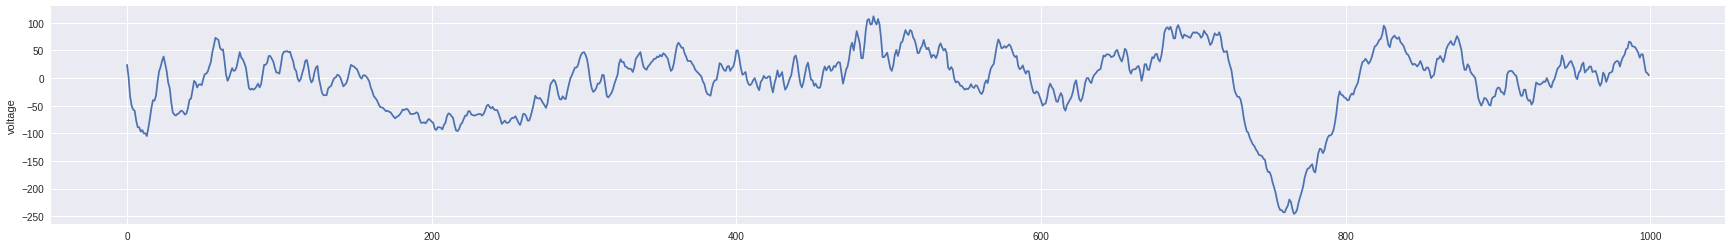

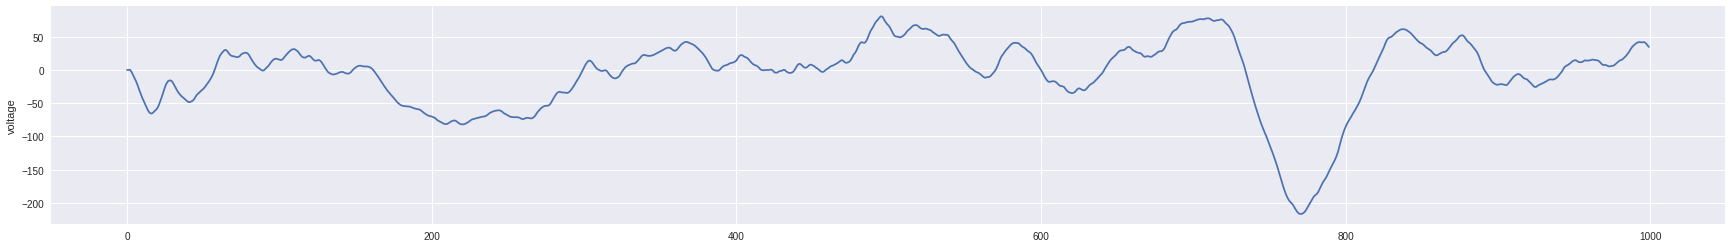

In [9]:

import matplotlib.pyplot as plt
m = loadmat('./output/Dog_5/Dog_5_preictal_segment_0006.mat')
d = m['preictal_segment_6'][0][0][0]

plt.figure(figsize=(30,4))
plt.plot(d[1][0:1000])

plt.ylabel('voltage')
plt.show()



plt.figure(figsize=(30,4))
plt.plot(momentum(d[1][0:1000]))

plt.ylabel('voltage')
plt.show()

In [0]:
#Window size * # of electrode channels gives us number of features - input to the NN

win_size = 39 #can be changed


def prepX (fname):
    
    dt_length = 0
    rm = loadmat('./output/Dog_5/' + fname)
    
    if 'inter' in fn:
        
        indx=int(fn[25:-4])
        rd = rm['interictal_segment_' + str(indx)][0][0][0]
        dt_length = math.floor (rd.shape[1] / win_size)
        Y = [0] * dt_length
    else:
       
        indx=int(fn[23:-4])
        rd = rm['preictal_segment_' + str(indx)][0][0][0]
        dt_length = math.floor (rd.shape[1] / win_size)
        Y = [1] * dt_length
    
    #print(dt_length)
    rd_filt = np.zeros((rd.shape[0],rd.shape[1]))

    for j in range(rd.shape[0]):
         rd_filt[j] = momentum(rd[j])
    
    
    data=[]
    for i in range(dt_length):
        data.append (rd_filt[:, i*win_size : i*win_size+win_size])
       
        
    X = []
    for j in range(dt_length):
        X.append (data[j].reshape(-1,1))

        
    return X, Y
    

In [11]:
#This is where we'll put prepocessed files
!mkdir processed

mkdir: cannot create directory ‘processed’: File exists


In [12]:
#This part takes a while
from random import shuffle
import pickle

fns  = []

posit = [fn for fn in os.listdir("./output/Dog_5/") if 'preictal' in fn]
negat = [fn for fn in os.listdir("./output/Dog_5/") if 'interictal' in fn]
shuffle(negat)

#posit = posit[:2]
#negat = negat[:2]

negat = negat[0:len(posit)]

fns = posit + negat
shuffle(fns)

for fn in fns:
    print(fn)
    X_f, Y_f = prepX(fn)

    
    dbfile = open('./processed/' + fn , 'wb')
      
    # pickle the preproced data
    pickle.dump([X_f, Y_f], dbfile)                   
    dbfile.close()
  


Dog_5_preictal_segment_0015.mat
Dog_5_interictal_segment_0012.mat
Dog_5_preictal_segment_0008.mat
Dog_5_preictal_segment_0009.mat
Dog_5_interictal_segment_0147.mat
Dog_5_interictal_segment_0195.mat
Dog_5_preictal_segment_0010.mat
Dog_5_preictal_segment_0028.mat
Dog_5_interictal_segment_0078.mat
Dog_5_preictal_segment_0016.mat
Dog_5_preictal_segment_0002.mat
Dog_5_interictal_segment_0374.mat
Dog_5_interictal_segment_0069.mat
Dog_5_preictal_segment_0022.mat
Dog_5_preictal_segment_0005.mat
Dog_5_preictal_segment_0006.mat
Dog_5_preictal_segment_0014.mat
Dog_5_interictal_segment_0423.mat
Dog_5_preictal_segment_0001.mat
Dog_5_preictal_segment_0030.mat
Dog_5_interictal_segment_0242.mat
Dog_5_interictal_segment_0388.mat
Dog_5_preictal_segment_0013.mat
Dog_5_preictal_segment_0004.mat
Dog_5_preictal_segment_0029.mat
Dog_5_preictal_segment_0007.mat
Dog_5_interictal_segment_0282.mat
Dog_5_interictal_segment_0276.mat
Dog_5_preictal_segment_0024.mat
Dog_5_interictal_segment_0402.mat
Dog_5_interictal

##Get the preprocessed data and feed into the model
---

In [0]:
#Read features from the pickled files
X_list = []
Y_list = []

prep_files = [fn for fn in os.listdir("./processed/")]

for f in prep_files:
   with open('./processed/' + f, 'rb') as f:
    X_f, Y_f = pickle.load(f)
    X_list.extend(X_f)
    Y_list.extend(Y_f)
       

In [14]:
len(X_list)

540936

In [15]:
len(Y_list)

540936

In [16]:
!ls

Dog_5.tar.gz  kaggle.json  output  processed  sample_data


In [0]:
X = np.asarray(X_list)
X = X.reshape(X.shape[0], X.shape[1])

Y = np.asarray(Y_list)
Y = Y.reshape(Y.shape[0],1)


In [18]:
X.shape

(540936, 585)

In [0]:
#Normalizing the feature values (very important for NNs)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [0]:
#Splitting into train/test sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, BatchNormalization

Using TensorFlow backend.


In [0]:
#Topology
model = Sequential()

model.add(Dense(100, input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(700))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [0]:

adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
#train the model
model.fit(X_train, Y_train, epochs=100, batch_size=1024)

Epoch 1/100
432748/432748 [==============================] - 9s 21us/step - loss: 0.6121 - acc: 0.6756
Epoch 2/100
432748/432748 [==============================] - 8s 18us/step - loss: 0.5775 - acc: 0.6976
Epoch 3/100
432748/432748 [==============================] - 8s 18us/step - loss: 0.5448 - acc: 0.7118
Epoch 4/100
432748/432748 [==============================] - 8s 17us/step - loss: 0.5312 - acc: 0.7186
Epoch 5/100
432748/432748 [==============================] - 8s 17us/step - loss: 0.5230 - acc: 0.7240
Epoch 6/100
432748/432748 [==============================] - 8s 17us/step - loss: 0.5179 - acc: 0.7272
Epoch 7/100
432748/432748 [==============================] - 8s 17us/step - loss: 0.5137 - acc: 0.7306
Epoch 8/100
432748/432748 [==============================] - 8s 17us/step - loss: 0.5104 - acc: 0.7328
Epoch 9/100
432748/432748 [==============================] - 8s 17us/step - loss: 0.5071 - acc: 0.7351
Epoch 10/100
432748/432748 [==============================] - 7s 17us/ste

In [0]:
#Get predictions for the test set
ytest = model.predict_classes(X_test)

In [26]:
#Confusion matrix 
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(Y_test, ytest))
print(roc_auc_score(ytest, Y_test))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82     71340
           1       0.67      0.61      0.63     36848

   micro avg       0.76      0.76      0.76    108188
   macro avg       0.74      0.72      0.73    108188
weighted avg       0.76      0.76      0.76    108188

0.7358076423276371
